# EVAC Examination

## Data Exploration

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime
import math
from sklearn.metrics import r2_score


In [51]:
num_input_nodes = 9
num_hidden_nodes_1 = 16
num_hidden_nodes_2 = 16
num_output_nodes = 1

NUM_WEIGHTS = (num_input_nodes * num_hidden_nodes_1) + (num_hidden_nodes_1 * num_hidden_nodes_2) + (num_hidden_nodes_2 * num_output_nodes)
NUM_BIASES = num_hidden_nodes_1 + num_hidden_nodes_2 + num_output_nodes

IND_SIZE = NUM_WEIGHTS + NUM_BIASES

In [52]:
all_data = pd.read_csv('eScooterDemand.csv')
all_data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No,Yes


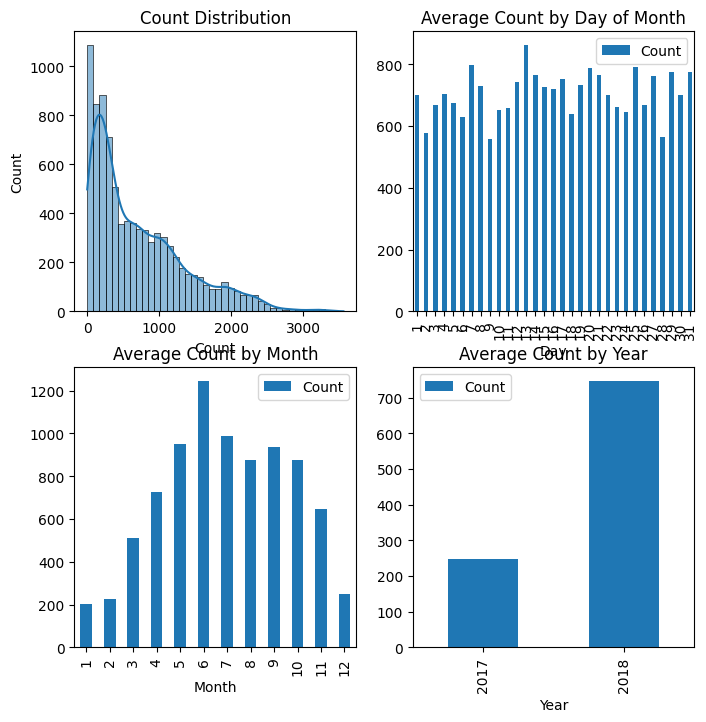

In [53]:


## plot average count over time to look for patterns that can be used to predict future demand
all_data['Date'] = pd.to_datetime(all_data['Date'], format='%d/%m/%Y')
all_data['Month'] = all_data['Date'].dt.month
all_data['Year'] = all_data['Date'].dt.year
all_data['Day'] = all_data['Date'].dt.day

## Show all plots on one figure
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
sns.histplot(all_data['Count'], kde=True, ax=ax[0, 0]).set_title('Count Distribution')
all_data.groupby('Day').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[0, 1], title='Average Count by Day of Month')
all_data.groupby('Month').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 0], title='Average Count by Month')
all_data.groupby('Year').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 1], title='Average Count by Year')

plt.show()


## Set up representation

In [54]:
!pip install deap

In [55]:
from deap import base, creator, tools, algorithms, gp, creator
import random
import operator
from IPython import display


In [56]:
## Prepare data for training
all_data['Windspeed'] = all_data['Wind speed']
all_data['HireAvailable'] = all_data['HireAvailable'].map({'Yes': 1, 'No': 0})
all_data['PublicHoliday'] = all_data['Public Holiday'].map({'Yes': 1, 'No': 0})
## Create a new column for weekend and assign 1 if the day is a weekend and 0 if it is not from date
all_data['Weekend'] = all_data['Date'].dt.dayofweek.map(lambda x: 1 if x > 4 else 0)
all_data['Season'] = all_data['Season'].map({'Spring': 0, 'Summer': 1, 'Autumn': 2, 'Winter': 3})
all_data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable,Month,Year,Day,Windspeed,PublicHoliday,Weekend
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,2.2,0,0
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,0.8,0,0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,3,No,1,12,2017,1,1.0,0,0
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,0.9,0,0
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,3,No,1,12,2017,1,2.3,0,0


In [57]:
all_data["Count"].describe()

count    8760.000000
mean      704.602055
std       644.997468
min         0.000000
25%       191.000000
50%       504.500000
75%      1065.250000
max      3556.000000
Name: Count, dtype: float64

In [58]:
## Data standardisation
from sklearn import preprocessing

features = [
 'Hour',
 'Temp',
 'Windspeed',
 'Visibility',
 'Dew point']
# for feature in features:
scaler = preprocessing.MinMaxScaler((0, 1))
# Fit the scaler to your data
scaler.fit(all_data[features])

# Transform the selected features
all_data[features] = scaler.transform(all_data[features])



In [59]:
features

['Hour', 'Temp', 'Windspeed', 'Visibility', 'Dew point']

In [60]:
class MLP(object):
    def __init__(self, numInput, numHidden1, numHidden2, numOutput):
        self.fitness = 0
        self.numInput = numInput
        self.numHidden1 = numHidden1
        self.numHidden2 = numHidden2
        self.numOutput = numOutput

        self.w_i_h1 = np.random.randn(self.numHidden1, self.numInput)
        self.w_h1_h2 = np.random.randn(self.numHidden2, self.numHidden1)
        self.w_h2_o = np.random.randn(self.numOutput, self.numHidden2)

        self.b_i_h1 = [0] * numHidden1
        self.b_i_h2 = [0] * numHidden2
        self.b_i_output = [0] * numOutput

        self.ReLU = lambda x : max(0,x)

    def sigmoid(self,x):
        try:
            ans = (1 / (1 + math.exp(-x)))
        except OverflowError:
            ans = float('inf')
        return ans

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    def feed_forward(self, inputs):

        h1 = np.dot(self.w_i_h1, inputs)             # feed input to hidden layer 1
        h1 = [h + b for h, b in zip(h1, self.b_i_h1)]

        h1 = [self.ReLU(x) for x in h1]              # Activate hidden layer1

        h2 = np.dot(self.w_h1_h2, h1)                # feed layer 1 to hidden layer 2
        h2 = [h + b for h, b in zip(h2, self.b_i_h2)]
        h2 = [self.ReLU(x) for x in h2]              # Activate hidden layer 2

        output = np.dot(self.w_h2_o, h2)             # feed to output layer
        output = [o + b for o, b in zip(output, self.b_i_output)]
        return output

    # Weights get set as:
    # Weights to layer h1, h2, o
    # Biases to layer h1, h2, o
    def set_weights_linear(self, Wgenome):
        numWeights_I_H1 = self.numHidden1 * self.numInput
        numWeights_H1_H2 = self.numHidden2 * self.numHidden1
        numWeights_H2_O = self.numOutput * self.numHidden2

        # Weights (multi-dimensional arrays)

        first_slice_end = numWeights_I_H1

        self.w_i_h1 = np.array(Wgenome[:first_slice_end])
        self.w_i_h1 = self.w_i_h1.reshape((self.numHidden1, self.numInput))

        second_slice_end = first_slice_end + numWeights_H1_H2

        self.w_h1_h2 = np.array(Wgenome[first_slice_end:second_slice_end])
        self.w_h1_h2 = self.w_h1_h2.reshape((self.numHidden2, self.numHidden1))

        third_slice_end = second_slice_end + numWeights_H2_O

        self.w_h2_o = np.array(Wgenome[second_slice_end:third_slice_end])
        self.w_h2_o = self.w_h2_o.reshape((self.numOutput, self.numHidden2))

        # Biases (flat arrays for each layer)

        fourth_slice_end = third_slice_end + self.numHidden1

        self.b_i_h1 = np.array(Wgenome[third_slice_end:fourth_slice_end])

        fith_slice_end = fourth_slice_end + self.numHidden2

        self.b_i_h2 = np.array(Wgenome[fourth_slice_end:fith_slice_end])

        self.b_i_output = np.array(Wgenome[fith_slice_end:])

    def get_weights(self):
        return np.concatenate((self.w_i_h1.flatten(), self.w_h1_h2.flatten(), self.w_h2_o.flatten(), self.b_i_h1, self.b_i_h2, self.b_i_output))

In [61]:
creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1.0, 1.0)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=IND_SIZE)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [62]:
import numpy
# randomise data
all_data = all_data.sample(frac=1).reset_index(drop=True)
test_data = all_data.sample(frac=0.2)
train_data = all_data.drop(test_data.index)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
print(all_data.size)
print(test_data.size)

print(train_data.size)
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)


175200
35040
140160


In [63]:

## Mean absolute error: On some regression problems, the distribution of the target variable may be mostly Gaussian, but may have outliers, e.g. large or small values far from the mean value.

def eval(individual, myNet, evdata):
  myNet.set_weights_linear(individual)
  fitness = 0
  preds = []
  for i in range(len(evdata)):
    input = [evdata['PublicHoliday'][i], evdata['Weekend'][i], evdata['Month'][i], evdata['Hour'][i], evdata['Temp'][i], evdata['Windspeed'][i], evdata['Visibility'][i], evdata["HireAvailable"][i], evdata['Dew point'][i]]
    output = myNet.feed_forward(input)
    preds.append(output)
    fitness += (evdata['Count'][i] - output[0])**2

  return fitness/len(evdata),





In [64]:
toolbox.register("evaluate", eval)

toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.5, indpb=0.5)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)


myNet = MLP(num_input_nodes, num_hidden_nodes_1, num_hidden_nodes_2, num_output_nodes)

baseline = toolbox.evaluate(myNet.get_weights(), myNet, train_data)
print(baseline)

(950242.8630185269,)


In [65]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [66]:
## SANITYY CHECK
ind = toolbox.individual()
print(ind)
print(ind.fitness.values)
print(len(ind.fitness.weights))
print(len(toolbox.evaluate(ind, myNet, train_data)))
print(ind.fitness.weights)
ind.fitness.values = toolbox.evaluate(ind, myNet, train_data)

print(ind.fitness.valid)
# print(myNet.feedForward([-10, 4, 3, 2, 1, 5, 5]))
print(toolbox.evaluate(ind, myNet, train_data))

[0.24213048210899246, -0.03506293962565121, 0.5807204629093519, -0.7932275353328619, 0.01320438041176275, 0.8087713302942665, 0.25070190054265296, -0.033415477276562466, -0.8789752301846745, 0.26365174986202344, -0.946264529223839, 0.18038014109076306, 0.2099994439260111, -0.47784586796442863, 0.7558079655441559, -0.5577961889802661, -0.3229582485808895, -0.7899114886312244, -0.5511831852072386, 0.7848292041047011, -0.6693034822719242, -0.5383412570047417, -0.9413518909612386, -0.6063497567471334, -0.6297569048242648, -0.6205710476145989, -0.8645101479427324, -0.4894325503567518, 0.6858039350990968, 0.7742797093613678, -0.3153714134051051, -0.09227148264245044, 0.9444253280919035, -0.5530902826185831, -0.5839103780696633, 0.2734154611193449, -0.8568891889409671, -0.5901511132840034, -0.6159856112768507, -0.12701562686312862, 0.032748584822999804, 0.3084741845678838, -0.20968176201727196, 0.990404803860647, 0.03294879933224393, 0.6903887946039857, -0.39654007383488743, 0.076772025277280

1
(-1.0,)
True
(917381.6878221307,)


In [67]:
logbook = tools.Logbook()
hof = tools.HallOfFame(1)
pop = toolbox.population(n=200)

In [68]:
fitnesses = [toolbox.evaluate(indiv, myNet, train_data) for indiv in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

In [69]:
NGEN = 500

for g in range(NGEN):
    print("-- Generation %i --" % g)
      
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values
                         
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(indiv, myNet, train_data) for indiv in invalid_ind]
    for ind, fit in zip(invalid_ind, fitnesses):
         ind.fitness.values = fit
    
    pop[:] = offspring
    record = stats.compile(pop)
    logbook.record(gen=g, **record)

    gen = [g] * 100
    hof.update(pop)
    if g%5==0:
      print(record)



-- Generation 0 --
{'avg': 898962.0456769165, 'std': 24682.366496624563, 'min': 807558.3793293812, 'max': 974796.8952115438}
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
{'avg': 697472.1405692464, 'std': 80298.11835586754, 'min': 471148.30399507284, 'max': 880569.1638512025}
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
{'avg': 471714.7937473264, 'std': 35607.769218378955, 'min': 417034.6085060742, 'max': 650631.3900846103}
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
{'avg': 441848.410861668, 'std': 36949.66860327429, 'min': 386226.19662229635, 'max': 609696.1138644835}
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --
-- Generation 20 --
{'avg': 422550.6772672617, 'std': 57630.62897266824, 'min': 353534.7863912473, 'max': 717657.8207969151}
-- Generation 21 --
-- Generation 22 --
-- Generation 23 --
--

KeyboardInterrupt: 

In [ ]:
print(logbook)
print([i[:1] for i in hof.items[:10]])



avg   	gen	max        	min   	std    
887804	0  	966368     	799649	26645.6
861416	1  	931777     	737990	34523.1
831203	2  	958582     	694180	49008.3
785129	3  	921209     	578963	54076.3
733665	4  	910273     	565219	69964.2
673733	5  	869804     	486719	70496.7
626908	6  	847543     	452527	74005  
561209	7  	751208     	424705	65707.9
511351	8  	673425     	418772	53824.9
478331	9  	692982     	415338	41537.7
465197	10 	640795     	408287	37089.9
455053	11 	594779     	396793	35736.1
448697	12 	612607     	382196	36342.5
437675	13 	576172     	381959	30722.3
439309	14 	717755     	368399	43135.6
431360	15 	792345     	358330	47306  
432297	16 	654067     	338647	49826.6
427471	17 	777014     	338129	56244.4
423223	18 	721647     	335735	57131.4
413450	19 	597123     	332780	53380.5
415980	20 	755368     	338677	63018.7
415389	21 	872905     	326884	74593.4
424032	22 	947549     	324829	93092.5
420319	23 	917719     	317312	90100.2
416147	24 	788129     	321706	77015.5
416839	25 	1

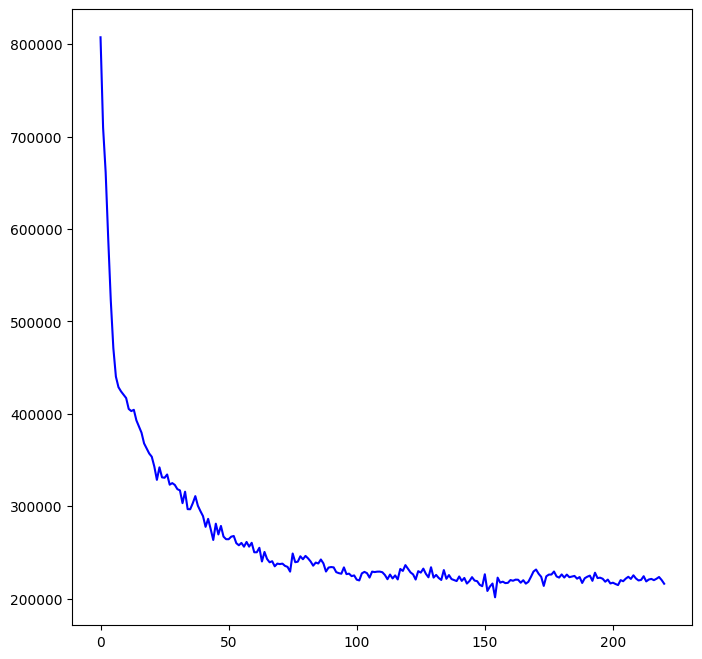

In [70]:
## graph of the min fitness value over generations
gen = logbook.select("gen")
fit_mins = logbook.select("min")
fit_maxs = logbook.select("max")
fit_avgs = logbook.select("avg")

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(gen, fit_mins, "b", label="Minimum")


[9.421491559778302, -2.4808753055908133, -6.0521444671786755, -5.8900649575829, 1.6566283542555484, -1.4673244021940097, -0.4661079101786618, -4.75316714486801, 3.612370685763752, -1.4051357962594042, -5.211982324943442, -1.3093577016593536, -3.0406322762698217, -2.353941435054152, 2.0116330426631484, -4.236067674235681, 0.33216748357605724, -7.210169912100605, 1.482311992847214, -0.24448371818957693, 2.975271196729602, 1.0643240812893695, 2.3266968431548114, 0.32152773720736433, -0.842311836214979, -1.451569761443859, 0.24635552343205602, 0.8811565606251088, 3.0387066697800225, 0.06865966011860125, 1.5989392104165743, -2.7913799497835767, -4.183438105412153, 3.095522029968877, -1.504639864943833, 3.6072307963677295, -2.439577907100881, 0.028826268975694236, 2.2618291628770346, -7.1067182718497826, -12.208927657805734, -0.9218808039698421, -4.317684579608641, -5.972027256415572, -9.896595484466092, -1.918275669518822, 2.6829801616273867, -2.83957201725826, 1.403634469245049, 6.07813898

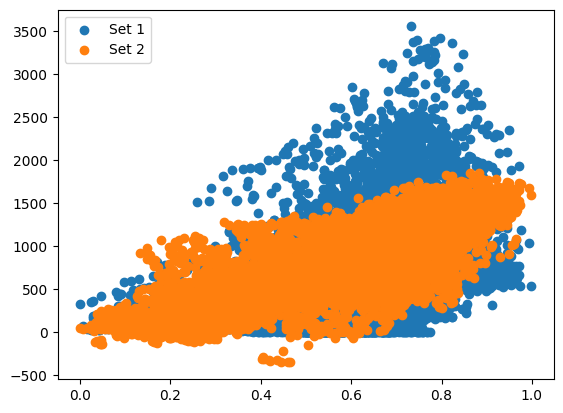

In [71]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

best_ind = hof[0]

print(best_ind)
print(toolbox.evaluate(best_ind, myNet, train_data))
myNet.set_weights_linear(best_ind)
inputs = [[train_data['PublicHoliday'][i], train_data['Weekend'][i], train_data['Month'][i], train_data['Hour'][i], train_data['Temp'][i], train_data['Windspeed'][i], train_data['Visibility'][i], train_data["HireAvailable"][i], train_data['Dew point'][i]] for i in range(len(train_data))]

x_values1 = train_data['Temp'].to_list()
y_values1 = train_data['Count'].to_list()

x_values2 = train_data['Temp'].to_list()
y_values2 = [myNet.feed_forward(i) for i in inputs] 

R2 = r2_score(y_values1, y_values2)
print(R2)
print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

[deap.creator.FitnessMax((191538.12774412648,))]

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

best_ind = hof[0]

print(best_ind)
print(toolbox.evaluate(best_ind, myNet, train_data))
myNet.set_weights_linear(best_ind)
inputs = [[test_data['PublicHoliday'][i], test_data['Weekend'][i], test_data['Month'][i], test_data['Hour'][i], test_data['Temp'][i], test_data['Windspeed'][i], test_data['Visibility'][i], test_data["HireAvailable"][i]] for i in range(len(test_data))]

x_values1 = test_data['Dew point'].to_list()
y_values1 = test_data['Count'].to_list()

x_values2 = test_data['Dew point'].to_list()
y_values2 = [myNet.feed_forward(i) for i in inputs] 

R2 = r2_score(y_values1, y_values2)
print(R2)
print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

[-0.7746475723276924, 10.683060464665639, 15.551363334932567, 2.2829470309405346, 1.6285255326690762, -1.4986854108202752, 9.281749497515467, 11.40758654275497, 7.318258258179534, 12.3049565313573, -5.073682692359083, -1.029270679184449, 19.066277730217628, 11.57611714248846, -14.84538456093352, 17.142130373260994, -11.953143994334022, -8.417008271602834, -2.383754068827801, -8.576486543544588, 2.170508990912961, -4.160686622013788, -2.8498184601078838, -2.244408362626744, 1.3722406892516374, 3.8897432009846247, -5.612553364326435, 6.799056967459344, 13.062298072938201, 1.1335928674919298, -5.58703311530526, 0.999507948635024, -0.8151648567009769, -4.523702617412722, -0.24695085802965355, -1.9041579557127164, 3.26165983350074, -3.4860831499914555, -5.6699562754205175, 0.08600068341504902, 9.016140127625922, 7.776329335885981, -0.5252049465466713, 25.59646563289159, -3.3045285351297133, -2.220806207540324, -8.704654008572628, -0.7970483025543331, -7.0192481446228365, 7.0487590739077, 0.

ValueError: shapes (16,9) and (8,) not aligned: 9 (dim 1) != 8 (dim 0)

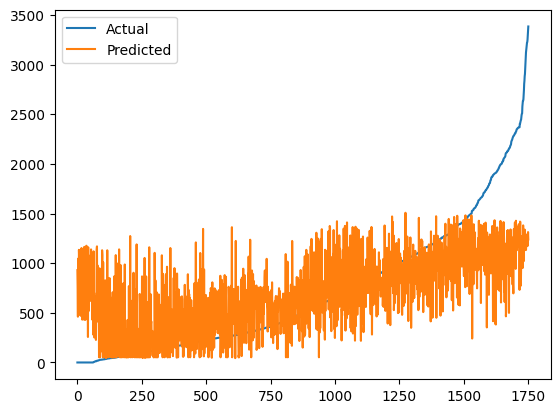

In [ ]:
best_ind = hof.items[0]

test_data.sort_values(by=['Count'], inplace=True)
test_data = test_data.reset_index(drop=True)
inputs = [[test_data['PublicHoliday'][i], test_data['Weekend'][i], test_data['Month'][i], test_data['Hour'][i], test_data['Temp'][i], test_data['Windspeed'][i], test_data['Visibility'][i], test_data["HireAvailable"][i], train_data["Dew point"][i]] for i in range(len(test_data))]
x = [i for i in range(len(test_data))]
y_values1 = test_data['Count'].to_list()
y_values2 = [myNet.feed_forward(i) for i in inputs]
plt.plot(x, y_values1, label='Actual')
plt.plot(x, y_values2, label='Predicted')
plt.legend()
plt.show()

[-1.8064883428754341, -3.9265798333225437, -1.8823799855649215, -5.324537465785179, -1.7201359509124856, 7.302084807465165, -3.7230534349906415, -3.5801173308020102, 4.870073932241842, -0.9516875147305217, 1.9816617807720671, 1.66203930660329, -0.3301188786043178, -0.14642904860904965, 1.0708451022939893, 0.3452874274444697, 1.999845506056788, 3.2124533287167134, 4.648747305907465, 2.116093918405072, -3.0411621134126587, 4.073316475697847, -1.9619744061329927, 1.847721806449336, -2.877293460492272, -4.351436772850911, -9.03998903745597, -2.1333004049034234, 1.6153046017529942, -0.3767565897899512, 1.2470743576161512, 2.194376134140887, -2.0296145962891563, -0.638981923238878, -5.0597924379889765, -3.970530391424252, -2.5255392995668613, 0.8789734190290797, -6.667058306748179, -3.710666325981543, 5.295944346218073, -5.154294252915754, -7.869326282908662, -1.4373101345675157, 3.9379895476099263, -7.444415933524057, -2.9449516469022115, -11.736318463828713, -2.7259009383993824, 4.22675298

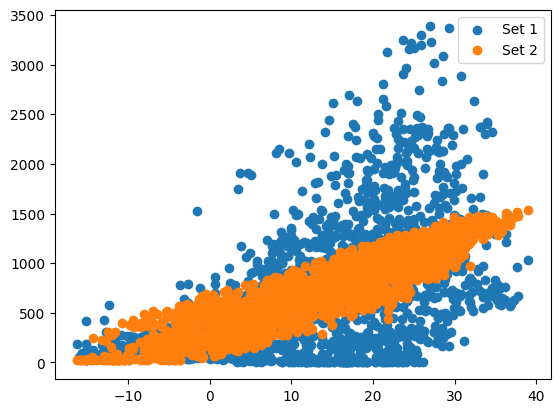

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

best_ind = hof.items[0]

print(best_ind)
print(toolbox.evaluate(best_ind, myNet, train_data))
print(toolbox.evaluate(best_ind, myNet, test_data))
myNet.set_weights_linear(best_ind)
inputs = [[test_data['Season'][i], test_data['PublicHoliday'][i], test_data['Weekend'][i], test_data['Month'][i], test_data['Hour'][i], test_data['Temp'][i], test_data['Windspeed'][i], test_data['Visibility'][i], test_data["HireAvailable"][i]] for i in range(len(test_data))]

x_values1 = test_data['Temp'].to_list()
y_values1 = test_data['Count'].to_list()

x_values2 = test_data['Temp'].to_list()
y_values2 = [myNet.feed_forward(i) for i in inputs] 

R2 = r2_score(y_values1, y_values2)
print(R2)
print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

[[708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337

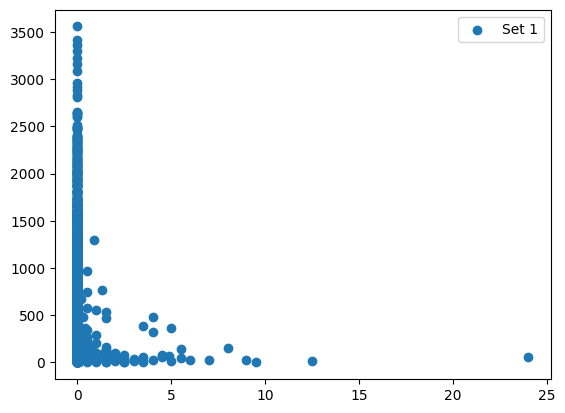

[29.096660147330937, 12.581272755715162, -0.38149388340117474, 4.957464629270712, 17.309974820025115, 11.415954409279552, -11.676366097190355, 0.046927422359391735, 9.779333286707804, 29.47839321443361, -5.395387520191839, 9.337687348597694, 14.92676670717382, -11.369634820100051, 26.64884397584116, 5.903664444034511, 15.717840450901218, 5.509973022960861, -24.074342490914763, 12.147669431831458, -5.429587036006186, 10.482114204623247, -11.919175301840948, 10.506377839387271, 1.6407556159264127, -11.942255391677476, 2.046754985028316, -4.5900594614014665, 17.106176546169976, -14.542911608606264, 4.4709820457791505, 1.5143974938124862, 12.675046211125776, 14.02482130623536, -8.205001241605178, 10.284344532687994, 9.542702385525882, 27.737329178993306, -7.330473267391048, 0.032744458846772684, -18.402472558215923, -7.099667658461653, 17.608404934296434, -4.666802491783139, -10.08339554606045, 7.750222360437842, 3.19722542153973, -5.676025704269632, -6.013707791185976, 10.8650930785805, -

In [ ]:
# Assuming you have two sets of data:
x_values1 = test_data['Rain'].to_list()
y_values1 = test_data['Count'].to_list()

# x_values2 = test_data['Rain'].to_list()
# y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
# plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()
print(best_ind)

In [ ]:
# Assuming you have two sets of data:
x_values1 = evdata['Month'].to_list()
y_values1 = evdata['Count'].to_list()

x_values2 = evdata['Month'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

NameError: name 'evdata' is not defined

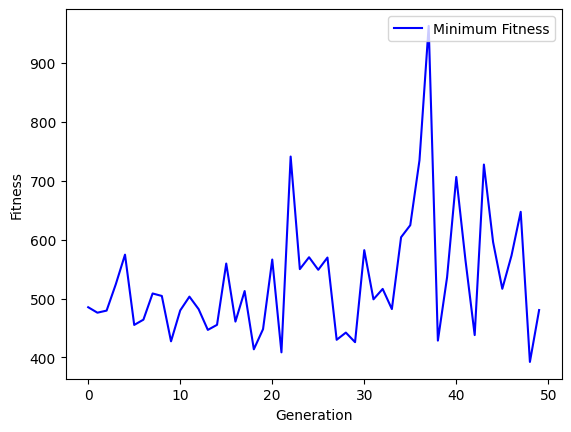

In [ ]:
## Graph fitness over generations

gen = logbook.select("gen")
fit_mins = logbook.select("min")


plt.plot(gen, fit_mins, "b-", label="Minimum Fitness")

plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper right")

plt.show()